In [1]:
import numpy as np

from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm import trange
from scipy import stats

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig4_supp/'

In [3]:
# define sessions
''' NEW LIST - updated 1/12/21 w/ NP9 and NP10 cohorts'''
''' run analysis on reasonable sessions N maps = 2 '''
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich (old)
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (new, NP9 = male)
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 13
N sessions: 28


In [4]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

session_colors = []
for m, session in zip(mice, sessions):
    for s in session:
        if m in ['Pisa', 'Hanover', 'Calais']:
            session_colors.append(cp_color)
        else:
            session_colors.append(cr_color)

In [5]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [6]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for probe mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for probe mistargeting
Toronto_1112_1 corrected for probe mistargeting
Mumbai_1130_1 corrected for probe mistargeting


In [7]:
print('N cells = {}'.format(N_cells))

N cells = 4984


In [8]:
# load the behavioral data
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        folder = base + m + '/'
        data_file = m + '_' + s + '_data.mat'
        behavior = get_data.loadData(folder + data_file)
        d['behavior'] = behavior

G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0430_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0501_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0502_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Hanover/Hanover_0615_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Calais/Calais_0713_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1005_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1006_1_data.mat

In [9]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [10]:
''' fit kmeans to get remaps '''
N = 2
model_kmeans = lvl_kmeans(n_components=N, n_restarts=100)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [11]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        H = d['kmeans']['H']
        
        # get map indices
        map_idx = W[:, 0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1
        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)

        # get running speed in each map and assign map 0 to slower map
        speed = A[:, 1]
        speed_0 = np.nanmean(speed[map0_idx])
        speed_1 = np.nanmean(speed[map1_idx])

        if speed_1 < speed_0: # swap labels
            d['map0_idx'] = 1
        else:
            d['map0_idx'] = 0

In [12]:
''' get distance to cluster on each trial '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        n_trials, n_cells, n_pos = Y.shape

        # get kmeans fit
        H = d['kmeans']['H']
        N = H.shape[0]
        map0_idx = d['map0_idx']

        # get centroids
        c1 = H[map0_idx]
        c2 = H[map0_idx-1]
        
        # project down to connecting line
        proj = (c1 - c2) / np.linalg.norm(c1 - c2)
        projc1 = c1 @ proj
        projc2 = c2 @ proj
        projY = Y_unwrapped @ proj
        
        # get distance
        dd = (projY - projc2) / (projc1 - projc2)
        d['dist'] = 2 * (dd - .5) # classify -1 or 1

In [13]:
# calculate each position's distance to cluster on each trial
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        n_trials, n_cells, n_pos = Y.shape
        
        map0_idx = d['map0_idx']
        H = d['kmeans']['H']
        N = H.shape[0]
        H_tens = H.reshape((N, n_cells, n_pos))

        # get each cluster
        c1 = H_tens[map0_idx, :, :]
        c2 = H_tens[map0_idx-1, :, :]
        proj = (c1 - c2) / np.linalg.norm(c1 - c2, axis=0, keepdims=True)

        projc1 = np.sum(c1 * proj, axis=0)[None, :]
        projc2 = np.sum(c2 * proj, axis=0)[None, :]
        projY = np.sum(Y * proj[None, :, :], axis=1)

        dd_by_pos = (projY - projc2) / (projc1 - projc2)
        dd_by_pos = 2 * (dd_by_pos - .5)
        d['pos_dist'] = dd_by_pos
        
        # calculate log likelihood
        W = d['kmeans']['W']
        n_pos = dd_by_pos.shape[1]
        K = np.tile(W[:, d['map0_idx']-1], (n_pos, 1))
        ll_pos = -K * np.log(1 + np.exp(dd_by_pos.T)) - (1 - K) * np.log(1 + np.exp(-dd_by_pos.T))
        d['ll_pos'] = ll_pos

In [14]:
''' save remap vs. stable index:
- limit "stable periods" to n_trials > 5
- stable trials = all trials except 4 trials surrounding remap point
- remap trials = two trials on each side of remap point
'''
near_N = 2
trial_min = 2*near_N + 1
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        W = d['kmeans']['W']
        trials = np.arange(0, W.shape[0]-1)

        # define remaps
        remap_idx = np.where(np.abs(np.diff(W[:, 0])))[0]
        
        # define stable
        for i in range(near_N):
            if i == 0:
                near_remaps = np.append(remap_idx, remap_idx+(i+1))
            elif i < near_N:
                near_remaps = np.append(np.append(near_remaps, remap_idx-i), remap_idx+(i+1))
        near_remaps = np.sort(near_remaps)
        stable_idx = np.setdiff1d(trials, near_remaps)
        
        # keep only remaps at least 5 trials from last remap (stable trials should by definition fit this bill)
        boundary_trials = np.insert(remap_idx, 0, 0)
        remap_idx = np.setdiff1d(remap_idx, remap_idx[np.diff(boundary_trials) < trial_min])
        remap_idx = np.sort(np.append(remap_idx, remap_idx+1))
        
        # save the data
        d['idx'] = [stable_idx, remap_idx]

In [15]:
''' get avg running speed on each trial '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]

        # speed
        A = d['A']
        speed = A[:, 1]
        obs_trials = A[:, 2]
        avg_speed = np.zeros_like(np.unique(obs_trials))
        for t in np.unique(obs_trials).astype(int):
            avg_speed[t] = np.mean(speed[obs_trials==t])
        d['avg_speeds'] = avg_speed

In [16]:
''' single session examples '''
# m = 'Pisa'
# s = '0430_1'
m = 'Toronto'
s = '1112_1'
d = data[m][s]

In [17]:
print('{}_{}, n cells = {}, n remaps = {}'.format(m, s, d['cells'].shape[0], d['idx'][1][::2].shape[0]))

Toronto_1112_1, n cells = 74, n remaps = 27


In [18]:
# get data
normalized_dd_all = d['dist']
A = d['A']
speed = A[:, 1]
obs_trials = A[:, 2]
avg_speed = d['avg_speeds']

In [19]:
# get avg speed for each stable block
stable_idx = d['idx'][0]
remap_idx = d['idx'][1]
remap_speeds_both = avg_speed[remap_idx]
remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2

# get avg stable speed by block
bdx = np.digitize(stable_idx, remap_idx[::2])
stable_blocks = np.zeros(remap_idx[::2].shape[0])
for b in np.unique(bdx):
    if b < stable_blocks.shape[0]:
        stable_blocks[b] = np.mean(avg_speed[stable_idx[bdx==b]])

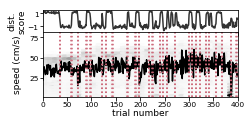

In [20]:
''' Fig. 4B - E -- examples running speed in remaps vs. stable '''
gs  = gridspec.GridSpec(4, 1, hspace=0, wspace=1.7)
f = plt.figure(figsize=(3.5, 1.6))
if m in ['Pisa', 'Hanover', 'Calais']:
    color = cp_color
else:
    color = cr_color
DIST_W = 1.5
SPEED_W = 1.5
REMAP_W = 1.5

# distance to cluster
ax0 = plt.subplot(gs[0])
ax0.plot(normalized_dd_all, color='k', lw=DIST_W, alpha=0.8)
ax0.set_xlim([0, normalized_dd_all.shape[0]])
xlim_ax0 = ax0.get_xlim()
ax0.set_yticks([-1, 1])
ax0.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)
ax0.set_ylabel('dist.\nscore', fontsize=9, labelpad=1)

# speed by trial
ax1 = plt.subplot(gs[1:])
ax1.hexbin(obs_trials, speed, gridsize=40, cmap='Greys')
ax1.plot(avg_speed, '-k', linewidth=SPEED_W, alpha=1)
ax1.set_ylabel('speed (cm/s)', fontsize=9, labelpad=7)
ax1.set_xlim(xlim_ax0)
ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
ax1.tick_params(which='major', labelsize=7.5, pad=0.5)

# remaps
ylim_ax1 = ax1.get_ylim()
for r in remap_idx:
    ax1.plot([r, r], ylim_ax1, ':', c=color, lw=REMAP_W, alpha=1)

f.savefig(save_folder + m + '_' + s + '_speed.png', dpi=400, bbox_inches='tight')
plt.show()

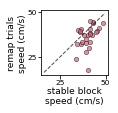

In [21]:
gs  = gridspec.GridSpec(1, 1, hspace=0, wspace=1.7)
f = plt.figure(figsize=(1.2, 1.2))
if m in ['Pisa', 'Hanover', 'Calais']:
    color = cp_color
else:
    color = cr_color
UNITY_W = 1
PT_SIZE = 20
PT_LW = 0.5

# stable vs. remaps
ax2 = plt.subplot(gs[0])
ax2.scatter(stable_blocks, remap_speeds, s=PT_SIZE, 
            facecolors=color, edgecolors='k', lw=PT_LW, alpha=0.7)
xlims = ax2.get_xlim()
ylims = ax2.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
ax2.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_W, alpha=0.7)

# labels
ax2.set_xticks([25, 50])
ax2.set_yticks([25, 50])
ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
ax2.set_xlabel('stable block\nspeed (cm/s)', fontsize=9, labelpad=1)
ax2.set_ylabel('remap trials\nspeed (cm/s)', fontsize=9, labelpad=1)

f.savefig(save_folder + m + '_' + s + '_speed_pairs.png', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
''' distance to boundary within each position bin on remap vs. stable trials--all mice '''
all_remap_dist = np.asarray([])
all_stable_dist = np.asarray([])
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        p_dist = d['pos_dist'] # trials x pos bins
        
        # get remap distances
        remap_idx = d['idx'][1]
        remap_dist = np.abs(p_dist[remap_idx, :])
        all_remap_dist = np.append(all_remap_dist, remap_dist.ravel())
        
        # get stable distances
        stable_idx = d['idx'][0]
        stable_dist = np.abs(p_dist[stable_idx, :])
        all_stable_dist = np.append(all_stable_dist, stable_dist.ravel())

In [23]:
print('mean, sem')
print('remap distance to bound: ' + str(np.round(np.mean(all_remap_dist), 3)) + 
      ', ' + str(np.round(stats.sem(all_remap_dist), 3)))
print('stable distance to bound: ' + str(np.round(np.mean(all_stable_dist), 3)) + 
      ', ' + str(np.round(stats.sem(all_stable_dist), 3)))
print('N remap trials = ' + str(all_remap_dist.shape[0]/80))
print('N stable trials = ' + str(all_stable_dist.shape[0]/80))

print('IQR stable blocks: ' + str(np.round(np.percentile(all_stable_dist, 25), 3)) + 
      ' to ' + str(np.round(np.percentile(all_stable_dist, 75), 3)))

stat, p_diff = stats.ranksums(all_stable_dist, all_remap_dist)
print('\nWilcoxon rank-sums, two-sided: p = ' + str(p_diff))

mean, sem
remap distance to bound: 0.59, 0.003
stable distance to bound: 1.044, 0.001
N remap trials = 290.0
N stable trials = 8064.0
IQR stable blocks: 0.762 to 1.338

Wilcoxon rank-sums, two-sided: p = 0.0


In [16]:
''' relationship between speed and distance to boundary -- all mice '''
# bin speed by position and trial
bin_size = 5 # cm
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed_file = base + 'aggregate_data/gap_corrected/' + m + '_' + s + '_speed.npy'
        if Path(speed_file).exists():
            d['binned_speed'] = np.load(speed_file)
        else:
            A = d['A']
            speed = A[:, 1]
            pos = A[:, 0]
            trials = A[:, 2]
            n_trials = np.max(trials+1).astype(int)
            edges = np.arange(0, 400+bin_size, bin_size)
            bdx = np.digitize(pos, edges)

            binned_speed = np.zeros((n_trials, n_pos))
            for t in np.unique(trials).astype(int):
                for i, b in enumerate(np.unique(bdx)):
                    idx = (trials==t) & (bdx==b)
                    binned_speed[t, i] = np.mean(speed[idx])

            np.save(speed_file, binned_speed)
            d['binned_speed'] = binned_speed

In [25]:
''' single session examples '''
# m = 'Toronto'
# s = '1112_1'
m = 'Pisa'
s = '0430_1'
d = data[m][s]
A = d['A']

In [17]:
def moving_avg(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [27]:
# get remap trial vs. middle of stable block indices
remaps = d['idx'][1][::2]
boundaries = np.insert(remaps, 0, 0)
stable_idx = moving_avg(boundaries, 2).astype(int)

In [28]:
# get speed near remaps vs. middle of stable blocks
binned_speed = d['binned_speed']
speed_remap = np.column_stack((binned_speed[remaps-1, :], binned_speed[remaps, :],
                                   binned_speed[remaps+1, :], binned_speed[remaps+2, :]))
speed_stable = np.column_stack((binned_speed[stable_idx-1, :], binned_speed[stable_idx, :],
                                   binned_speed[stable_idx+1, :], binned_speed[stable_idx+2, :]))

# get distance by position bin near remaps vs. middle of stable blocks
dd_by_pos = d['pos_dist']
pos_remaps = np.column_stack((dd_by_pos[remaps-1], dd_by_pos[remaps], 
                              dd_by_pos[remaps+1], dd_by_pos[remaps+2]))
pos_stable = np.column_stack((dd_by_pos[stable_idx-1], dd_by_pos[stable_idx], 
                              dd_by_pos[stable_idx+1], dd_by_pos[stable_idx+2]))

In [29]:
# example trials to plot
to_plot = np.asarray([6, 7, 10]) # Pisa
# to_plot = np.asarray([0, 5, 14]) # Vancouver
# to_plot = np.asarray([0, 23, -1]) # Toronto

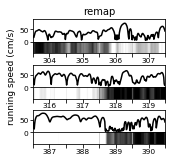

In [31]:
''' Fig. 4f, g -- examples of distance to boundary and running speed near remap points vs. mid-stable blocks '''
n_trials = pos_remaps.shape[0]
gs  = gridspec.GridSpec(12, 2, hspace=0, wspace=0.1)
f = plt.figure(figsize=(5, 2.5))
LW_SPEED = 1.5
MAX_SPEED = 90

rows = np.arange(0, 12-2, 4)
xvals = np.arange(0, 4*400, 5)                       
for i, r in zip(to_plot, rows):
    if m == 'Toronto':
        # STABLE
        ax01 = plt.subplot(gs[r:r+2, 0])
        ax11 = plt.subplot(gs[r+2, 0])

        # plot running speed
        ax01.plot(xvals, speed_stable[i], '-k', lw=LW_SPEED)
        ax01.set_ylim([0, MAX_SPEED])
        ax01.set_xticks(np.arange(0, 4*400+5, 200))
        ax01.set_xlim([0, 4*400])
        ax01.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

        # plot dd_pos
        ax11.imshow(pos_stable[None, i, :], clim=[-1, 1], aspect='auto', cmap='binary')
        ax11.set_xticks(np.arange(0, 4*80+5, 40))
        ax11.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
        ax11.tick_params(axis="y", which ="both", left=False)
    
    # REMAP
    ax00 = plt.subplot(gs[r:r+2, 1])
    ax10 = plt.subplot(gs[r+2, 1])
    
    # plot running speed
    ax00.plot(xvals, speed_remap[i], '-k', lw=LW_SPEED)
    ax00.set_ylim([0, MAX_SPEED])
    ax00.set_xlim([0, 4*400])
    ax00.set_xticks(np.arange(0, 4*400+5, 200))

    # plot dd_pos
    ax10.imshow(pos_remaps[None, i, :], clim=[-1, 1], aspect='auto', cmap='binary')
    ax10.set_xticks(np.arange(0, 4*80+5, 40))
    ax10.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    ax10.tick_params(axis="y", which ="both", left=False)

    # get trial numbers
    X_LABELS_REMAP = []
    X_LABELS_STABLE = []
    j = -1
    for t in range(12):
        if np.isin(t, np.asarray([1, 3, 5, 7])):
            X_LABELS_REMAP.append('{}'.format(remaps[i] + j))
            X_LABELS_STABLE.append('{}'.format(stable_idx[i] + j))
            j += 1
        else:
            X_LABELS_REMAP.append('')
            X_LABELS_STABLE.append('')
    
    # set axis labels
    if m == 'Toronto':
        ax00.tick_params(labelleft=False, labelbottom=False, 
                         which='major', labelsize=7.5, pad=0.5)
        ax11.set_xticklabels(X_LABELS_STABLE)
        if r == rows[1]:
            ax01.set_ylabel('running speed (cm/s)', fontsize=9, labelpad=3)
        elif r == 0:
            ax00.set_title('remap', fontsize=10, pad=5)
            ax01.set_title('stable', fontsize=10, pad=5)
    else:
        ax00.tick_params(labelbottom=False, which='major', 
                         labelsize=7.5, pad=0.5)
        if r == rows[1]:
            ax00.set_ylabel('running speed (cm/s)', fontsize=9, labelpad=3)
        elif r == 0:
            ax00.set_title('remap', fontsize=10, pad=5)
    
    
    
    ax10.set_xticklabels(X_LABELS_REMAP)

f.savefig(save_folder + m + '_' + s + '_transitions_speed_rewards.png', dpi=400, bbox_inches='tight')
plt.show()

In [32]:
scores_by_speed = np.zeros((N_sessions, 9))
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed = d['A'][:, 1]
        binned_speed = d['binned_speed']
        flat_speed = binned_speed.ravel()
        dd_by_pos = d['pos_dist']
        flat_pos = dd_by_pos.ravel()
        
        # define bins
        speed_bins = np.linspace(2, np.max(speed)-20, num=9)
        speed_idx = np.digitize(flat_speed, speed_bins)
        
        # get score for each speed bin
        for j, b in enumerate(np.unique(speed_idx)):
            scores_by_speed[i, j] = np.mean(np.abs(flat_pos[speed_idx==b]))
        i += 1

In [18]:
def nan_interp(y):
    def find(x):
        return x.nonzero()[0]
    nans = np.isnan(y)
    y[nans] = np.interp(find(nans),find(~nans),y[~nans])
    return y

def zscore(a):
    z = a - np.mean(a)
    z /= z.std()
    idx = np.abs(z) > 2

    new_a = a.copy()
    new_a[idx] = np.nan
    new_a = nan_interp(new_a)

    return new_a

In [34]:
# get parameters
slow_all = np.asarray([])
fast_all = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_speed = d['binned_speed'].copy()
        dd_by_pos = d['pos_dist'].copy()
        
        # normalize dd_by_pos and flip sign for random 50% to correct for arbitrary map
        flat_pos = dd_by_pos.ravel()
        norm_pos = zscore(flat_pos)
        flip_idx = (np.random.rand(flat_pos.shape[0]//2)*flat_pos.shape[0]).astype(int)
        norm_pos[flip_idx] = -1*norm_pos[flip_idx]
        
        # get speed cut-offs
        flat_speed = binned_speed.ravel()
        slow_speed = np.percentile(flat_speed, 20)
        fast_speed = np.percentile(flat_speed, 80)
        
        # collect z-scored distances
        slow_all = np.append(slow_all, norm_pos[flat_speed <= slow_speed])
        fast_all = np.append(fast_all, norm_pos[flat_speed >= fast_speed])

C:\Users\ilow1\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal


In [35]:
from sklearn.mixture import GaussianMixture

# fit a Gaussian mixture model to fast and slow
model_slow = GaussianMixture(n_components=2)
model_slow.fit(slow_all[:, None])
f1_slow = stats.norm(model_slow.means_[0], np.sqrt(model_slow.covariances_[0]))
f2_slow = stats.norm(model_slow.means_[1], np.sqrt(model_slow.covariances_[1]))

model_fast = GaussianMixture(n_components=2)
model_fast.fit(fast_all[:, None])
f1_fast = stats.norm(model_fast.means_[0], np.sqrt(model_fast.covariances_[0]))
f2_fast = stats.norm(model_fast.means_[1], np.sqrt(model_fast.covariances_[1]))

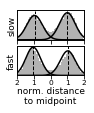

In [36]:
''' Fig. 4m -- distance to bound, slow vs. fast speeds'''
f, ax = plt.subplots(2, 1, figsize=(1.2, 1.2))
plt.subplots_adjust(hspace=0.2)
color = 'k'
MODEL_WIDTH = 1.5
MEAN_WIDTH = 1

# plot dist to cluster vs. model fit SLOW
ax[0].hist(slow_all, bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 200)
ax2 = ax[0].twinx()
ax2.plot(xvals, model_slow.weights_[0] * f1_slow.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_slow.weights_[1] * f2_slow.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_slow.means_, 0, ax2.get_ylim()[1], linestyles='dashed', colors='k', lw=MEAN_WIDTH)
x_min = ax[0].get_xlim()[0]
x_max = ax[0].get_xlim()[1]
ax2.set_yticks([0, 0.5])
ax[0].tick_params(labelbottom=False, labelleft=False)
ax2.tick_params(labelright=False, axis="y", which ="both", right=False)

# plot dist to cluster vs. model fit FAST
ax[1].hist(fast_all, bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[1].get_xlim()[0], ax[1].get_xlim()[1], 200)
ax2 = ax[1].twinx()
ax2.plot(xvals, model_fast.weights_[0] * f1_fast.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_fast.weights_[1] * f2_fast.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_fast.means_, 0, ax2.get_ylim()[1], linestyles='dashed', colors='k', lw=MEAN_WIDTH)
x_min = np.min((ax[1].get_xlim()[0], x_min))
x_max = np.max((ax[1].get_xlim()[1], x_max))
ax2.set_yticks([0, 0.5])

ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax2.tick_params(labelright=False, axis="y", which ="both", right=False)
ax[0].tick_params(axis="y", which ="both", left=False)
ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax[1].tick_params(axis="y", which ="both", left=False)

ax[0].set_xlim(x_min+1, x_max-1)
ax[1].set_xlim(x_min+1, x_max-1)
ax[1].set_xticks([-2, -1, 0, 1, 2])
ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticklabels([2, 1, 0, 1, 2])
ax[0].set_ylabel('slow', fontsize=9, labelpad=1)
ax[1].set_ylabel('fast', fontsize=9, labelpad=1)
ax[1].set_xlabel('norm. distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + 'speed_hist_all.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
''' single session examples '''
# m = 'Pisa'
# s = '0430_1'
m = 'Toronto'
s = '1112_1'
d = data[m][s]

In [38]:
dd_by_pos = d['pos_dist']
binned_speed = d['binned_speed']
speed = d['A'][:, 1]
speed_bins = np.linspace(2, np.max(speed)-20, num=9)
speed_idx = np.digitize(binned_speed.ravel(), speed_bins)
flat_pos = dd_by_pos.ravel()

scores_by_speed_mean = np.zeros(9)
scores_by_speed_sem = np.zeros(9)
scores_by_speed_std = np.zeros(9)
for i, b in enumerate(np.unique(speed_idx)):
    scores_by_speed_mean[i] = np.mean(np.abs(flat_pos[speed_idx==b]))
    scores_by_speed_sem[i] = stats.sem(np.abs(flat_pos[speed_idx==b]))
    scores_by_speed_std[i] = np.std(np.abs(flat_pos[speed_idx==b]))

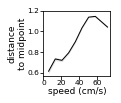

In [39]:
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))

xvals = moving_avg(np.append(speed_bins, np.max(binned_speed)), 2)
ax.plot(xvals, scores_by_speed_mean, 'k', linewidth=1)
ax.fill_between(xvals, scores_by_speed_mean + scores_by_speed_sem,
                scores_by_speed_mean - scores_by_speed_sem, color='k', linewidth=0.3, alpha=0.1)

if m == 'Toronto':
    ax.set_yticks([0.6, 0.8, 1.0, 1.2])
else:
    ax.set_yticks([0.8, 1.0, 1.2])

if m == 'Pisa':
    ax.set_xticks([0, 20, 40, 60, 80])
else:
    ax.set_xticks([0, 20, 40, 60])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('speed (cm/s)', fontsize=9, labelpad=1)
ax.set_ylabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + m + '_' + s + '_dd_by_speed.png', dpi=400, bbox_inches='tight')
plt.show()

In [40]:
flat_pos = dd_by_pos.ravel()
flat_speed = binned_speed.ravel()
slow_speed = np.percentile(flat_speed, 20)
fast_speed = np.percentile(flat_speed, 80)

# fit a Gaussian mixture model to fast and slow
model_slow = GaussianMixture(n_components=2)
model_slow.fit(flat_pos[flat_speed<=slow_speed, None])
f1_slow = stats.norm(model_slow.means_[0], np.sqrt(model_slow.covariances_[0]))
f2_slow = stats.norm(model_slow.means_[1], np.sqrt(model_slow.covariances_[1]))

model_fast = GaussianMixture(n_components=2)
model_fast.fit(flat_pos[flat_speed>=fast_speed, None])
f1_fast = stats.norm(model_fast.means_[0], np.sqrt(model_fast.covariances_[0]))
f2_fast = stats.norm(model_fast.means_[1], np.sqrt(model_fast.covariances_[1]))

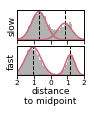

In [41]:
f, ax = plt.subplots(2, 1, figsize=(1.2, 1.2))
plt.subplots_adjust(hspace=0.2)
if m in ['Pisa', 'Hanover', 'Calais']:
    color = cp_color
else:
    color = cr_color
MODEL_WIDTH = 1.5
MEAN_WIDTH = 1

# SLOW
# histogram of distance to cluster (slowest 20%)
ax[0].hist(flat_pos[flat_speed<=slow_speed], 
           bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 200)

# model fit
ax2 = ax[0].twinx()
ax2.plot(xvals, model_slow.weights_[0] * f1_slow.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_slow.weights_[1] * f2_slow.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_slow.means_, 0, ax2.get_ylim()[1], 
           linestyles='dashed', colors='k', lw=MEAN_WIDTH)

# FAST
# histogram of distance to cluster (fastest 20%)
ax[1].hist(flat_pos[flat_speed>=fast_speed],
           bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[1].get_xlim()[0], ax[1].get_xlim()[1], 200)

# model fit
ax3 = ax[1].twinx()
ax3.plot(xvals, model_fast.weights_[0] * f1_fast.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax3.plot(xvals, model_fast.weights_[1] * f2_fast.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax3.set_ylim([0, ax3.get_ylim()[1]])
ax3.vlines(model_fast.means_, 0, ax3.get_ylim()[1], 
           linestyles='dashed', colors='k', lw=MEAN_WIDTH)

# SET AXIS PARAMS
ax[1].set_xticks([-2, -1, 0, 1, 2])
ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticklabels([2, 1, 0, 1, 2])

ax[0].tick_params(labelbottom=False, labelleft=False)
ax[0].tick_params(axis="y", which ="both", left=False)
ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax[1].tick_params(axis="y", which ="both", left=False)
ax2.tick_params(labelbottom=False, labelright=False, 
                axis="y", which ="both", right=False)
ax3.tick_params(labelright=False, axis="y", which ="both", right=False)

ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[0].set_ylabel('slow', fontsize=9, labelpad=1)
ax[1].set_ylabel('fast', fontsize=9, labelpad=1)
ax[1].set_xlabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + m + '_' + s + '_speed_hist.png', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
''' normalized running speed vs. track location - all mice (originally part of Fig. 1)'''
avg_speeds = np.zeros((N_sessions, 200))
sem_speeds = []
all_positions = np.asarray([])
all_speeds = np.asarray([])
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        d = data[m][s]
        A = d['A']
        
        # running speed by position
        speed = A[:, 1].copy()
        posx = A[:, 0]
        pos_bin = 2 # cm
        
        # normalize running speed
        norm_speed = (speed - np.min(speed)) / (np.max(speed) - np.min(speed))

        # bin speed into position bins
        x_max = np.round(np.max(posx),-2)
        edges = np.arange(0, x_max + 2*pos_bin, pos_bin)
        b_idx = np.digitize(posx, edges)

        binned_speed = np.zeros(np.unique(b_idx).shape[0])
        sem_speed = np.zeros(np.unique(b_idx).shape[0])
        for j, b in enumerate(np.unique(b_idx)):
            binned_speed[j] = np.mean(norm_speed[b_idx == b])
            sem_speed[j] = stats.sem(norm_speed[b_idx == b])
        
        # save everything
        avg_speeds[i, :] = binned_speed
        sem_speeds.append(sem_speed)
        all_positions = np.append(all_positions, posx)
        all_speeds = np.append(all_speeds, norm_speed)

In [17]:
for i, avg in enumerate(avg_speeds):
    if i == 0:
        avg_array = avg
    else:
        avg_array = np.row_stack((avg_array, avg))
        
speed_25 = np.percentile(avg_array, 25, axis=0)
speed_75 = np.percentile(avg_array, 75, axis=0)

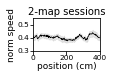

In [18]:
# plot mean over a hist showing the distribution, like in S7F, G
f, ax = plt.subplots(1, 1, figsize=(1.2, 0.6))
positions = np.arange(0, 400, pos_bin)

ax.plot(positions, np.mean(avg_array, axis=0), color='k', lw=0.75)
ax.fill_between(positions, np.mean(avg_array, axis=0) + stats.sem(avg_array, axis=0), 
                np.mean(avg_array, axis=0) - stats.sem(avg_array, axis=0), 
                color='k', lw=0.5, alpha=0.1)
# ax.fill_between(positions, speed_25, speed_75, 
#                 color='k', lw=0.5, alpha=0.1)
ax.set_ylim([0.3, 0.55])
ax.set_xlim([0, 400])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_title('2-map sessions', fontsize=10, pad=3)
ax.set_xlabel('position (cm)', fontsize=9, labelpad=1)
ax.set_ylabel('norm speed', fontsize=9, labelpad=1)

f.savefig(save_folder + 'speed_by_pos_all.png', dpi=400, bbox_inches='tight')
plt.show()

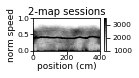

In [184]:
# plot mean over a hist showing the distribution, like in S7F, G
f, ax = plt.subplots(1, 1, figsize=(1.5, 0.6))
positions = np.arange(0, 400, pos_bin)

im = ax.hexbin(all_positions, all_speeds, 
               gridsize=50, clim=[1000, 3500], cmap='Greys')
ax.plot(positions, np.mean(avg_array, axis=0), color='k', lw=1.5)

ax.set_ylim([0, 1])
ax.set_xlim([0, 400])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_title('2-map sessions', fontsize=10, pad=3)
ax.set_xlabel('position (cm)', fontsize=9, labelpad=1)
ax.set_ylabel('norm speed', fontsize=9, labelpad=1)

cbar = f.colorbar(im, ticks=np.arange(1e3, 4e3, 1e3))
cbar.ax.tick_params(labelsize=7.5)

f.savefig(save_folder + 'speed_by_pos_all_hist.png', dpi=400, bbox_inches='tight')
plt.show()

In [19]:
''' REWARDS AND LANDMARKS '''
''' get and format reward info '''
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        d['reward_data'] = {}
        
        # get behavioral params
        behave_data = d['behavior']
        post = behave_data['post']
        posx = behave_data['posx']
        trial = get_data.trial_idx(posx)
        lickt = behave_data['lickt']
        
        # get reward info
        reward = behave_data['reward']
        reward_centers = np.array(reward['centers'])
        rewardt = reward['times']
        auto_reward = reward['auto']
        misses = reward['miss'].astype(bool)
        reward_trials = reward['trials']

        # find estimated reward times for misses
        missed_centers = reward_centers[misses]
        missed_trials = reward_trials[misses]
        missed_trials = missed_trials[missed_trials%100 > 0]

        for t in np.unique(missed_trials):
            trial_pos = posx[trial == t]
            trial_t = post[trial == t]
            trial_centers = missed_centers[missed_trials == t]

            for c in trial_centers:
                idx = np.argmin(np.abs(trial_pos - c))
                rewardt[(reward_trials == t) & (reward_centers == c)] = trial_t[idx]

        # get lick and reward indices
        lick_ct = get_data.spiketrain(post, dt, lickt, index=False)
        reward_idx = get_data.spiketrain(post, dt, rewardt, index=True)
        d['reward_data']['lick_ct'] = lick_ct
        d['reward_data']['reward_idx'] = reward_idx
        d['reward_data']['centers'] = reward_centers
        d['reward_data']['trials'] = reward_trials

In [20]:
# calculate similarity score across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [21]:
''' systematic differences in running speed across maps? 
compare running speed in adjacent blocks of trials from the two maps (to account for changes in running speed over time)
'''
# get fractional change in speed between maps
d_speed = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        avg_speed = d['avg_speeds']
        
        # get remap indices
        W = d['kmeans']['W']
        map0 = d['map0_idx']
        remaps = np.where(np.abs(np.diff(W[:, map0])))[0]
        if remaps.shape[0]%2==0:
            remaps = remaps[:-1]
            
        # get average running speed for each block of trials
        speed_0 = np.zeros(remaps.shape[0]//2)
        speed_1 = np.zeros(remaps.shape[0]//2)
        t0 = 0
        i = -1
        if W[0, map0]:
            for t1, t2 in zip(remaps[0::2], remaps[1::2]):
                i += 1               
                speed_0[i] = np.mean(avg_speed[t0:t1])
                speed_1[i] = np.mean(avg_speed[t1:t2])
                t0 = t2
        else:
            for t1, t2 in zip(remaps[0::2], remaps[1::2]):
                i += 1               
                speed_0[i] = np.mean(avg_speed[t1:t2])
                speed_1[i] = np.mean(avg_speed[t0:t1])
                t0 = t2
        
        # get fractional change in speed across neighboring blocks and store results
        d_speed = np.append(d_speed, (speed_1 - speed_0)/speed_0)

In [139]:
# shuffled fractional change in speed
num_shuffs = 1000
d_speed_shuff = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        avg_speed = d['avg_speeds']
            
        # get remap indices
        W = d['kmeans']['W']
        map0 = d['map0_idx']
        remaps = np.where(np.abs(np.diff(W[:, map0])))[0]
        if remaps.shape[0]%2==0:
            remaps = remaps[:-1]    
        
        for shuffle in range(num_shuffs):
            # get shuffled speed per block
            shuff_speed = avg_speed.copy()
            np.random.shuffle(shuff_speed)
            speed_0 = np.zeros(remaps.shape[0]//2)
            speed_1 = np.zeros(remaps.shape[0]//2)
            t0 = 0
            i = -1
            if W[0, map0]:
                for t1, t2 in zip(remaps[0::2], remaps[1::2]):
                    i += 1               
                    speed_0[i] = np.mean(shuff_speed[t0:t1])
                    speed_1[i] = np.mean(shuff_speed[t1:t2])
                    t0 = t2
            else:
                for t1, t2 in zip(remaps[0::2], remaps[1::2]):
                    i += 1               
                    speed_0[i] = np.mean(shuff_speed[t1:t2])
                    speed_1[i] = np.mean(shuff_speed[t0:t1])
                    t0 = t2

            # get fractional change in speed across neighboring blocks and store results
            if np.mean(speed_0) < np.mean(speed_1):
                d_speed_shuff = np.append(d_speed_shuff, (speed_1 - speed_0)/speed_0)
            else:
                d_speed_shuff = np.append(d_speed_shuff, (speed_0 - speed_1)/speed_1)  

C:\Users\ilow1\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ilow1\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


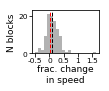

In [146]:
# compare true mean and shuffled mean
f, ax = plt.subplots(1, 1, figsize=(1.2, 0.8))

# plot changes in speed for all remap sessions
ax.hist(d_speed, color='k', bins=20, alpha=0.3)
# ax.hist(d_speed_shuff, color='r', bins=20000, alpha=0.3)

# plot mean vs. shuffle mean
ax_ylim = ax.get_ylim()
ax.vlines(np.nanmedian(d_speed_shuff), ax_ylim[0], ax_ylim[1], color='r', 
          linestyles='dashed', lw=1, alpha=1, label='shuff')
ax.vlines(np.nanmedian(d_speed), ax_ylim[0], ax_ylim[1], color='k', 
          linestyles='dashed', lw=1, alpha=1, label='true')
ax.set_xticks(np.arange(-0.5, 1.75, 0.5))
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])
# ax.set_xlim([-0.25, 1.75])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('frac. change\nin speed', fontsize=9, labelpad=1)
ax.set_ylabel('N blocks', fontsize=9, labelpad=2)
# ax.legend(bbox_to_anchor=(1,1,0,0))

f.savefig(save_folder + '/speed_vs_maps.png', dpi=400, bbox_inches='tight')
plt.show()

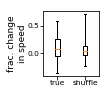

In [180]:
# compare true vs. shuffle - box and whisker
f, ax = plt.subplots(1, 1, figsize=(1, 1.2))

bplot = ax.boxplot((d_speed, d_speed_shuff), 
                   labels=['true', 'shuffle'], 
                   whis=[2.5, 97.5],
                   showfliers=False
                  )

ax.tick_params(which='major', labelsize=7.5, pad=0.5)
# ax.set_ylim((-0.75, 1.75))
ax.set_ylabel('frac. change\nin speed', fontsize=9, labelpad=1)

f.savefig(save_folder + '/speed_vs_maps_box.png', dpi=400, bbox_inches='tight')
plt.show()

In [153]:
# significantly different than shuffle?
print('mean percent change in running speed, sem = {}, {}'.format(np.round(np.mean(d_speed*100), 2), 
                                                                  np.round(stats.sem(d_speed*100), 2)))
speed_stat, speed_p = stats.ranksums(d_speed, d_speed_shuff)
print('fractional change in speed across maps vs. shuffled (rank sums): p = {}'.format(speed_p))

# vs. 95% of shuff
pct_95 = np.percentile(d_speed_shuff, 95)
p05 = (np.sum(d_speed > pct_95) / d_speed.shape[0])*100

print('{:.2f}% of block pairs had a greater change in speed than 95% of shuffle'.format(p05))

mean percent change in running speed, sem = 12.28, 2.68
fractional change in speed across maps vs. shuffled (rank sums): p = 0.02593934283773642
5.94% of block pairs had a greater change in speed than 95% of shuffle


In [41]:
np.mean(ll_pos, axis=1).shape

(80,)

In [22]:
''' distance to cluster by track position '''
# get all distances across sessions
all_ll_pos = np.asarray([])
avg_ll_pos = np.asarray([])
all_ll_pos_cp = np.asarray([])
avg_ll_pos_cp = np.asarray([])
all_ll_pos_cr = np.asarray([])
avg_ll_pos_cr = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        ll_pos = d['pos_dist'].copy()
        ll_pos = ll_pos.T
        ll_pos = np.abs(ll_pos)
        ll_pos = zscore(ll_pos)
        
        if all_ll_pos.shape[0] == 0:
            all_ll_pos = ll_pos # save all trials for all sessions
            avg_ll_pos = np.mean(ll_pos, axis=1) # avg w/in session
        else:
            all_ll_pos = np.column_stack([all_ll_pos, ll_pos])
            avg_ll_pos = np.column_stack([avg_ll_pos, np.mean(ll_pos, axis=1)])   
            
        # split by cue rich/poor
        if m in mice[:3]: # cue poor
            if all_ll_pos_cp.shape[0] == 0:
                all_ll_pos_cp = ll_pos # save all trials for all sessions
                avg_ll_pos_cp = np.mean(ll_pos, axis=1) # avg w/in session
            else:
                all_ll_pos_cp = np.column_stack([all_ll_pos_cp, ll_pos])
                avg_ll_pos_cp = np.column_stack([avg_ll_pos_cp, np.mean(ll_pos, axis=1)])
        else:
            if all_ll_pos_cr.shape[0] == 0:
                all_ll_pos_cr = ll_pos # save all trials for all sessions
                avg_ll_pos_cr = np.mean(ll_pos, axis=1) # avg w/in session
            else:
                all_ll_pos_cr = np.column_stack([all_ll_pos_cr, ll_pos])
                avg_ll_pos_cr = np.column_stack([avg_ll_pos_cr, np.mean(ll_pos, axis=1)])

In [23]:
# compute shuffled ll_pos
n_shuffs = 1000
max_shift = 400/5
all_shuffs_cp = np.asarray([])
all_shuffs_cr = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        ll_pos = d['pos_dist'].copy()
        ll_pos = ll_pos.T
        ll_pos = np.abs(ll_pos)
        ll_pos = zscore(ll_pos)
        
        # shuffle distances
        mat_shape = ll_pos.shape
        flat_pos = np.ravel(ll_pos, order='F')
        shifts = (np.random.rand(n_shuffs, 1)*max_shift).astype(int)
            
        # split by cue rich/poor
        if m in mice[:3]: # cue poor
            for i, k in enumerate(shifts):
                shuff_pos = np.roll(flat_pos, k, axis=0)
                shuff_mat = np.reshape(shuff_pos, mat_shape, order='F')
                if all_shuffs_cp.shape[0] == 0:
                    all_shuffs_cp = np.mean(shuff_mat, axis=1)
                else:
                    all_shuffs_cp = np.column_stack([all_shuffs_cp, np.mean(shuff_mat, axis=1)])
        else:
            for i, k in enumerate(shifts):
                shuff_pos = np.roll(flat_pos, k, axis=0)
                shuff_mat = np.reshape(shuff_pos, mat_shape, order='F')
                if all_shuffs_cr.shape[0] == 0:
                    all_shuffs_cr = np.mean(shuff_mat, axis=1)
                else:
                    all_shuffs_cr = np.column_stack([all_shuffs_cr, np.mean(shuff_mat, axis=1)])

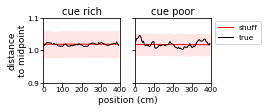

In [24]:
# distance to cluster by position - CUE RICH VS. POOR, EQUAL WEIGHTED SESSIONS
gs  = gridspec.GridSpec(1, 2, hspace=0, wspace=0.2)
f = plt.figure(figsize=(3, 1.2))
xvals = np.arange(0, 400, 5)

# cue rich sessions
ax0 = plt.subplot(gs[0])
MEAN = np.mean(all_ll_pos_cr, axis=1)
SHUFF_MEAN = np.mean(all_shuffs_cr, axis=1)
SHUFF_LOW = np.percentile(all_shuffs_cr, 2.5, axis=1)
SHUFF_HIGH = np.percentile(all_shuffs_cr, 97.5, axis=1)

ax0.fill_between(xvals, SHUFF_LOW, SHUFF_HIGH, color='r', linewidth=0.2, alpha=0.1, zorder=2)
ax0.plot(xvals, SHUFF_MEAN, 'r', linewidth=1, alpha=1, zorder=1)
ax0.plot(xvals, MEAN, 'k', linewidth=1, zorder=3, label='true')

# cue poor sessions
ax1 = plt.subplot(gs[1])
MEAN = np.mean(all_ll_pos_cp, axis=1)
SHUFF_MEAN = np.mean(all_shuffs_cp, axis=1)
SHUFF_LOW = np.percentile(all_shuffs_cp, 5, axis=1)
SHUFF_HIGH = np.percentile(all_shuffs_cp, 95, axis=1)

ax1.fill_between(xvals, SHUFF_LOW, SHUFF_HIGH, color='r', linewidth=0.2, alpha=0.1, zorder=2)
ax1.plot(xvals, SHUFF_MEAN, 'r', linewidth=1, alpha=1, zorder=1, label='shuff')
ax1.plot(xvals, MEAN, 'k', linewidth=1, zorder=3, label='true')

# set y-axes
[ax0_min, ax0_max] = ax0.get_ylim()
[ax1_min, ax1_max] = ax1.get_ylim()
y_min = np.min([ax0_min, ax1_min])
y_max = np.max([ax0_max, ax1_max])
ax0.set_ylim([0.9, 1.1])
ax1.set_ylim([0.9, 1.1])
# ax0.set_ylim([y_min, y_max])
# ax1.set_ylim([y_min, y_max])

# label axes etc
ax0.set_xticks(np.arange(0, 450, 100))
ax1.set_xticks(np.arange(0, 450, 100))
ax0.set_xlim([0, 400])
ax1.set_xlim([0, 400])
ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)

ax1.set_xlabel('position (cm)', fontsize=9, labelpad=3, horizontalalignment='right', x=0.3)
ax0.set_ylabel('distance\nto midpoint', fontsize=9, labelpad=1)
ax0.set_title('cue rich', fontsize=10, pad=3)
ax1.set_title('cue poor', fontsize=10, pad=3)
ax1.legend(bbox_to_anchor=(1,1,0,0), fontsize=7.5)

f.savefig(save_folder + 'dd_by_pos_env.png', dpi=400, bbox_inches='tight')
plt.show()

In [25]:
''' distance to cluster by distance to/from reward '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        trials = A[:, 2].astype(int)
        centers = d['reward_data']['centers']
        reward_trials = d['reward_data']['trials']
        trial_pos = np.arange(2.5, 402.5, 5)
        n_trials = (np.max(trials)+1).astype(int)
        
        # get reward centers
        reward_idx = np.zeros((n_trials, n_pos))
        for t in np.unique(trials):
            if t in reward_trials:
                for c in centers[reward_trials==t]:
                    idx = np.argmin(np.abs(trial_pos - c))
                    reward_idx[t, idx] = 1
        reward_idx = reward_idx.astype(bool)
                    
        # get distances
        distance_template = np.arange(-50, 55, 5)
        flat_idx = np.ravel(reward_idx)
        flat_dist = np.full(flat_idx.shape[0], np.nan)
        for i in np.where(flat_idx)[0]:
            flat_dist[i-10:i+11] = distance_template
        reward_dist = np.reshape(flat_dist, reward_idx.shape)
                    
        d['reward_dist'] = reward_dist

In [26]:
# get distance to boundary by distance to/from reward
scores_by_rew = np.zeros((N_sessions, 21))
prox_bins = distance_template + 2.5
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_reward = d['reward_dist'].copy()
        flat_reward = binned_reward.ravel()
        dd_by_pos = d['pos_dist'].copy()
        flat_pos = dd_by_pos.ravel()
        
        # define bins
        prox_idx = np.digitize(flat_reward, prox_bins)
        
        # get score for each speed bin
        for j, b in enumerate(np.unique(prox_idx)[:-1]):
            scores_by_rew[i, j] = np.mean(np.abs(flat_pos[prox_idx==b]))
        i += 1

In [27]:
norm_scores_by_rew = np.zeros_like(scores_by_rew)

for i in range(scores_by_rew.shape[0]):
    norm_scores_by_rew[i, :] = zscore(scores_by_rew[i, :])

In [28]:
# compute shuffle for reward
prox_bins = distance_template + 2.5
n_shuffs = 1000
max_shift = 400/5
shuff_scores = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_reward = d['reward_dist'].copy()
        flat_reward = binned_reward.ravel(order='F')
        dd_by_pos = d['pos_dist'].copy()
        flat_pos = dd_by_pos.ravel(order='F')
        
        # define bins
        prox_idx = np.digitize(flat_reward, prox_bins)
        
        # shuffle distances
        shifts = (np.random.rand(n_shuffs, 1)*max_shift).astype(int)
        for i, k in enumerate(shifts):
            shuff_pos = np.roll(flat_pos, k, axis=0)
            # get score for each reward bin
            scores_by_rew = np.zeros(21)
            for j, b in enumerate(np.unique(prox_idx)[:-1]):
                scores_by_rew[j] = np.mean(np.abs(shuff_pos[prox_idx==b]))
            if shuff_scores.shape[0] == 0:
                shuff_scores = scores_by_rew
            else:
                shuff_scores = np.column_stack([shuff_scores, scores_by_rew])

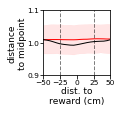

In [29]:
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
xvals = distance_template
MEAN = np.mean(norm_scores_by_rew, axis=0)
SHUFF_MEAN = np.mean(shuff_scores, axis=1)
SHUFF_LOW = np.percentile(shuff_scores, 2.5, axis=1)
SHUFF_HIGH = np.percentile(shuff_scores, 97.5, axis=1)

# plot data and shuffle
ax.fill_between(xvals, SHUFF_LOW, SHUFF_HIGH, color='r', linewidth=0.2, alpha=0.1, zorder=1)
ax.plot(xvals, SHUFF_MEAN, 'r', linewidth=1, alpha=1, zorder=2)
ax.plot(xvals, MEAN, 'k', linewidth=1, zorder=3)

# plot reward zone
ax.vlines([-25, 25], [0.9, 0.9], [1.1, 1.1], linestyles='dashed', color='k', linewidth=1, alpha=0.5)

# labels, axes
ax.set_ylim([0.9, 1.1])
ax.set_xlim([-50, 50])
ax.set_xticks(np.arange(-50, 55, 25))
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('dist. to\nreward (cm)', fontsize=9, labelpad=1)
ax.set_ylabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + 'dd_by_reward_zone.png', dpi=400, bbox_inches='tight')
plt.show()

In [123]:
''' get distance to boundary by distance to/from reward (negative = approaching, positive = leaving)
see if sign flips systematically (i.e. remaps occur) in reward zone
'''
scores_by_rew = np.zeros((N_sessions, 21))
flips = np.zeros(N_sessions)
prox_bins = distance_template + 2.5
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_reward = d['reward_dist'].copy()
        flat_reward = binned_reward.ravel(order='C')
        dd_by_pos = d['pos_dist'].copy()
        flat_pos = dd_by_pos.ravel(order='C')
        
        # define bins
        prox_idx = np.digitize(flat_reward, prox_bins)
        bins, cts = np.unique(prox_idx, return_counts=True)
        bins = bins[:-1]
        cts = cts[:-1]
        N_bins = bins.shape[0]
        N_rewards = np.max(cts)
        
        # get the scores for each reward/bin
        scores_matrix = np.zeros((N_rewards, N_bins))
        all_starts = np.where(prox_idx==np.argmax(cts))[0] - np.argmax(cts)
        for j, b in enumerate(bins):
            bin_scores = flat_pos[prox_idx==b]
            if bin_scores.shape[0] == N_rewards:
                scores_matrix[:, j] = flat_pos[prox_idx==b]
            else:
                starts = np.where(prox_idx==b)[0] - b
                skip_idx = np.in1d(all_starts, starts)
                scores_matrix[skip_idx, j] = bin_scores
                scores_matrix[~skip_idx, j] = np.nan
                
        # get the avg sign entering and apply to exiting
        avg_enter = np.mean(scores_matrix[:, :N_bins//2], axis=1)
        signs = (avg_enter >= 0).astype(int)
        signs[signs==0] = -1
        signed_scores = scores_matrix * np.tile(signs, (21, 1)).T
        scores_by_rew[i, :] = np.nanmean(signed_scores, axis=0)
        
        # save the % of bins where sign flips occurred
        flips[i] = (np.sum(signed_scores < 0) / (N_rewards*N_bins))*100

        i += 1

C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less


In [131]:
# compute the % flips for each session's shuffle
prox_bins = distance_template + 2.5
n_shuffs = 1000
max_shift = 200/5
shuff_flips = np.zeros((N_sessions, n_shuffs))
l = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_reward = d['reward_dist'].copy()
        flat_reward = binned_reward.ravel(order='C')
        dd_by_pos = d['pos_dist'].copy()
        mat_shape = dd_by_pos.shape
        flat_pos = dd_by_pos.ravel(order='F')
        
        # define bins
        prox_idx = np.digitize(flat_reward, prox_bins)
        bins, cts = np.unique(prox_idx, return_counts=True)
        bins = bins[:-1]
        cts = cts[:-1]
        N_bins = bins.shape[0]
        N_rewards = np.max(cts)
        
        # shuffle distances
        shifts = (np.random.rand(n_shuffs, 1)*max_shift).astype(int)
        for i, k in enumerate(shifts):
            shuff_pos = np.roll(flat_pos, k, axis=0)
            shuff_mat = np.reshape(shuff_pos, mat_shape, order='F')
            shuff_pos = np.ravel(shuff_mat, order='C')
            
            # get the scores for each reward/bin
            scores_matrix = np.zeros((N_rewards, N_bins))
            all_starts = np.where(prox_idx==np.argmax(cts))[0] - np.argmax(cts)
            for j, b in enumerate(bins):
                bin_scores = flat_pos[prox_idx==b]
                if bin_scores.shape[0] == N_rewards:
                    scores_matrix[:, j] = flat_pos[prox_idx==b]
                else:
                    starts = np.where(prox_idx==b)[0] - b
                    skip_idx = np.in1d(all_starts, starts)
                    scores_matrix[skip_idx, j] = bin_scores
                    scores_matrix[~skip_idx, j] = np.nan

            # get the avg sign entering and apply to exiting
            avg_enter = np.mean(scores_matrix[:, :N_bins//2], axis=1)
            signs = (avg_enter >= 0).astype(int)
            signs[signs==0] = -1
            signed_scores = scores_matrix * np.tile(signs, (21, 1)).T
            shuff_scores = np.nanmean(signed_scores, axis=0)

            # save the % of bins where sign flips occurred
            shuff_flips[l, k] = (np.sum(shuff_scores < 0) / (N_rewards*N_bins))*100
        l += 1

In [115]:
norm_scores_by_rew = np.zeros_like(scores_by_rew)
for i in range(scores_by_rew.shape[0]):
    norm_scores_by_rew[i, :] = zscore(scores_by_rew[i, :])

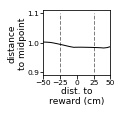

In [117]:
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
xvals = distance_template
MEAN = np.mean(norm_scores_by_rew, axis=0)
SHUFF_MEAN = np.mean(shuff_scores, axis=1)
SHUFF_LOW = np.percentile(shuff_scores, 2.5, axis=1)
SHUFF_HIGH = np.percentile(shuff_scores, 97.5, axis=1)

# plot data and shuffle
# ax.fill_between(xvals, SHUFF_LOW, SHUFF_HIGH, color='r', linewidth=0.2, alpha=0.1, zorder=1)
# ax.plot(xvals, SHUFF_MEAN, 'r', linewidth=1, alpha=1, zorder=2)
ax.plot(xvals, MEAN, 'k', linewidth=1, zorder=3)

# plot reward zone
ax.vlines([-25, 25], [0.9, 0.9], [1.1, 1.1], linestyles='dashed', color='k', linewidth=1, alpha=0.5)

# labels, axes
# ax.set_ylim([0.9, 1.1])
ax.set_xlim([-50, 50])
ax.set_xticks(np.arange(-50, 55, 25))
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('dist. to\nreward (cm)', fontsize=9, labelpad=1)
ax.set_ylabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + 'dd_by_reward_zone.png', dpi=400, bbox_inches='tight')
plt.show()

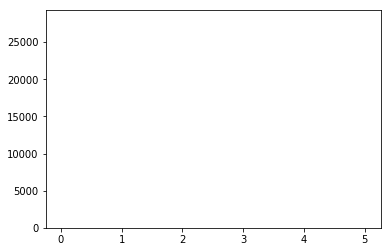

In [132]:
plt.hist(flips, color='k')
plt.hist(np.ravel(shuff_flips), bins=1000, color='r')
plt.show()

In [133]:
shuff_flips

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])